Valsecchi et al. (2014) show that, in the limit of large $M_{\rm p}/M_\star$ and conservative mass transfer, $a/a_0 = \left(M_{\rm p}/M_{\rm p,\ 0} \right)^{-1/3}$ (Eqn 14), where $a/a_0$ is the final/initial semi-major axis and $M_{\rm p}/M_{\rm p,\ 0}$ the final/initial planetary mass. Based on this equation, where would we expect the remnants of hot Jupiters that have lost their atmospheres to end up?


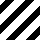
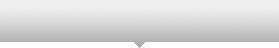
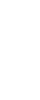
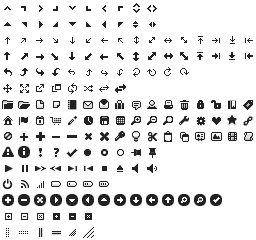
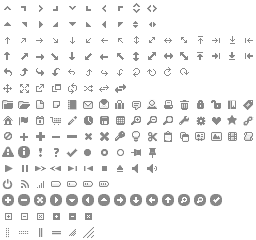
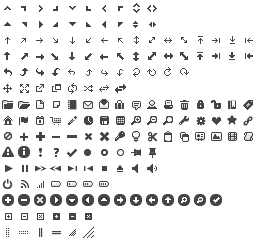
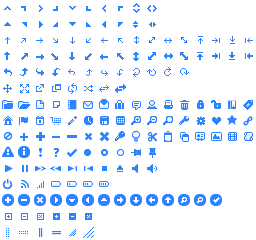
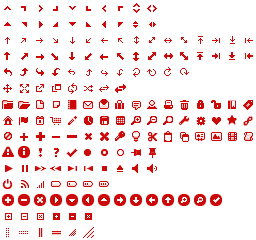
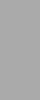
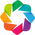
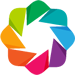
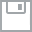
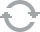
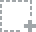
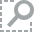
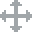
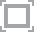
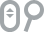

In [28]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import brentq
import matplotlib._cntr as cntr

import astropy.units as u
from astropy.units import cds
from astropy.table import Table

import bokeh.plotting
bokeh.plotting.output_notebook()

from collections import OrderedDict
from bokeh.plotting import figure, show, ColumnDataSource, output_file
from bokeh.models import HoverTool

plt.rcParams['contour.negative_linestyle'] = 'solid'

#Default aspect ratio for google slides
aspect_ratio = 4./3
default_fig_size = 6. #inches
default_fig_width = aspect_ratio*default_fig_size
default_fig_height = default_fig_size #"Heighth" is not a word.

In [2]:
def calc_smallq_roche_limit(q, Rp=0.1):
    return (q/3.)**(-1./3)*Rp

def Rappaport_Roche_limit(Mp=None, Rp=None, rhop=None, incompressible=False):
    #Returns Roche limit period for given density
    #  based on Rappaport+ (2013) ApJL 773, L15 -- 
    #  http://iopscience.iop.org/article/10.1088/2041-8205/773/1/L15/meta

    if(rhop is None):
        rhop = Mp/(4.*np.pi/3.*Rp**3.)

    #For a planet comprised of a highly compressible fluid
    period0 = 9.6/24.*u.day #days

    #A body comprised of an incompressible fluid with negligible bulk tensile strength
    if(incompressible):
        period0 = 12.6/24.*u.day #days
          
    return period0*np.sqrt(1.*u.g/u.cm**3/(rhop.to('g/cm^3')))

#Returns period or semi-major axis, given the other
#  P in days, a in AU, and Mstar in solar masses
def Keplers_Third_Law(P=None, a=None, Mstar=1.*cds.Msun):

    bigG = 4.*np.pi*np.pi/cds.Msun*(cds.au*cds.au*cds.au)/(cds.yr*cds.yr)

    if((P is None) and (a is None)):
        raise ValueError("P or a must be given!")
    elif(a is not None):
        return (a*a*a/(bigG*Mstar/(4.*np.pi*np.pi)))**(1./2)
    elif(P is not None):
        return (P*P*(bigG*Mstar/(4.*np.pi*np.pi)))**(1./3)

def tidal_decay_time(a0=0.05*cds.AU, a=0.01*cds.AU, Mstar=1.*cds.Msun, 
                     Rstar=1.*cds.Rsun, Mp=1.*cds.Mjup, Qstar=1e6):
    return 4./117*(a0**(13/2.) - a**(13./2))/(np.sqrt(cds.G/Mstar)*(Mp*Rstar**5)/Qstar)

def tidal_decay(a0=0.05*cds.AU, t=1e9*u.year, Mstar=1.*cds.Msun, 
                Rstar=1.*cds.Rsun, Mp=1.*cds.Mjup, Qstar=1e6):
    return (a0**(13./2) - 117./4*(np.sqrt(cds.G/Mstar)*(Mp*Rstar**5)/Qstar)*t)**(2./13)
    
print(Rappaport_Roche_limit(rhop=0.5*u.g/u.cm**3, incompressible=True).to('hour'))
print(tidal_decay(t=1e8*u.year, Qstar=1e5))

17.8190908859 h
0.0491193996859 AU


In [3]:
#typical hot Jupiter
Mp = 1.*cds.Mjup
Rp = 1.*cds.Rjup
Mcore = 10.*cds.Mgeo

#the Sun
Ms = 1.*cds.Msun
Rs = 1.*cds.Rsun

q = (Mp.to('kg')/Ms.to('kg')).value

a_Roche = calc_smallq_roche_limit(q, Rp=Rp)
P_Roche = Rappaport_Roche_limit(Mp, Rp)

#So where would the planet end up?
a = a_Roche*(Mcore/Mp)**(-1./3)
P = Keplers_Third_Law(a=a, Mstar=Ms)
print(a.to('au').value, P_Roche.to('day').value, P.to('day').value)

(0.02217335479484554, 0.35913876991932986, 1.2059723035426975)


Not too bad!

In [4]:
#These models come from Lopez & Fortney (2013 -- http://iopscience.iop.org/article/10.1088/0004-637X/792/1/1/meta)

def Lopez_core_radius(Mcore):
    MEarth = 1.*cds.Mgeo
    REarth = 1.*cds.Rgeo
    
    return ((Mcore/MEarth).value)**(0.25)*REarth

def Lopez_Renv(Mp, fenv=0.05, Fp=1., age=5e9*u.year):
    MEarth = 1.*cds.Mgeo
    fenv_baseline = 0.05
    Fp_baseline = 1.
    age_baseline = 5e9*u.year
    
    return 2.06*cds.Rgeo*((Mp/MEarth).value)**(-0.21)*\
            (fenv/fenv_baseline)**(0.59)*\
            (Fp/Fp_baseline)**(0.044)*\
            ((age/age_baseline).value)**(-0.18)

#Ignores the apparently small contribution from the radiative exterior
def Lopez_superearth_radius(Mp, fenv=0.05, Fp=1., age=5e9*u.year):
    Mcore = (1. - fenv)*Mp
#    Mcore = Mp
    Rcore = Lopez_core_radius(Mcore)
    
    Renv = Lopez_Renv(Mp, fenv=fenv, Fp=Fp, age=age)
    
    return (Rcore + Renv).value

print(Lopez_superearth_radius(20.*cds.Mgeo, fenv=19./20, Fp=1000., age=2e9*u.year))

10.9711384705


{8: '8', 2: '$2\\ {\\rm R_{Earth}}$', 4: '4', 6: '6'}


(-3.1, 0.1)

//anaconda/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
//anaconda/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


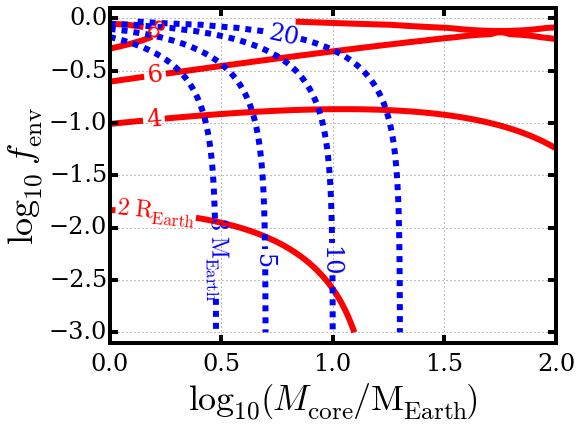

In [6]:
Mcores = 10**(np.linspace(0., 2., 100))*cds.Mgeo
fenvs = 10**(np.linspace(-3., 0., 101))
#Drop the very last one so I don't get a divide-by-zero error
fenvs = fenvs[:-1]

Mps = np.empty((len(Mcores), len(fenvs)))
Rps = np.empty((len(Mcores), len(fenvs)))
for i in range(len(Mcores)):
    for j in range(len(fenvs)):
        
        cur_Mp = Mcores[i]/(1. - fenvs[j])
        Mps[i,j] = cur_Mp.value
        Rps[i,j] = Lopez_superearth_radius(cur_Mp, fenv=fenvs[j])

fenvs = np.outer(np.ones_like(fenvs), fenvs)
Mcores = np.outer(Mcores, np.ones_like(Mcores))

fig = plt.figure(figsize=(default_fig_width, default_fig_height))
ax = fig.add_subplot(111)

locations = [(0.2, -2.), (0.2, -1.), (0.2, -0.5), (0.2, -0.1)]
lvls = [2, 4, 6, 8]
fmt = {lvls[0]: '$%i\ {\\rm R_{Earth}}$' % lvls[0]}
fmt.update({lvls[i]: '%i' % lvls[i] for i in range(1, len(lvls))})
print(fmt)
CS = ax.contour(np.log10(Mcores), np.log10(fenvs), Rps, colors='r', linewidths=6, levels=lvls)
ax.clabel(CS, inline=1, fontsize=24, fmt=fmt, manual=locations)

locations = [(0.5, -2.3), (0.7, -2.3), (1., -2.3), (0.8, 0.)]
lvls = [3, 5, 10, 20]
fmt = {lvls[0]: '$%i\ {\\rm M_{Earth}}$' % lvls[0]}
fmt.update({lvls[i]: '%i' % lvls[i] for i in range(1, len(lvls))})
CS = ax.contour(np.log10(Mcores), np.log10(fenvs), Mps, colors='b', linewidths=6, linestyles='dashed', levels=lvls)
ax.clabel(CS, inline=1, fontsize=24, 
          fmt={3: '$%i\ {\\rm M_{Earth}}$' % 3, 5:'%i' % 5, 10:'%i' % 10, 20:'%i' % 20}, manual=locations)

ax.set_xlabel('$\\log_{10} \\left( M_{\\rm core}/{\\rm M_{Earth}}\\right)$', fontsize=36)
ax.set_ylabel('$\\log_{10}\ f_{\\rm env}$', fontsize=36)

ax.set_xlim([0, 2])
ax.set_ylim([-3.1, 0.1])

#fig.savefig('LopezFortney2013_mass-radius_contours.eps', dpi=1000, bbox_inches='tight')

In [5]:
def calc_fenv(Mp, Rp, Fp=1., age=5e9):
    Renv0 = 2.06
#    age0 = 30e6 #years
    age0 = 5e9 #years
    fenv0 = 0.05
    
    #Assumes Earth mass
    Rcore = Mp**0.25

    #Assumes Earth radius
    Renv = Rp - Rcore
    
    return ((Renv/Renv0)*(Mp**(0.21))/(Fp**0.044)*(age/age0)**(0.18))**(1./0.59)*fenv0

In [30]:
LF_Table7 = Table.read('combined_LopezFortney2014_Table7_exoplanets-org.csv', format='ascii.csv')
#print(LF_Table7['H/He Envelope Fraction'])

#Add in the calculated core mass
LF_Table7['Mcore'] = LF_Table7['Mass (M_oplus)']*(1. - LF_Table7['H/He Envelope Fraction'])
print(LF_Table7)

Planet Name Mass (M_oplus) Radius (R_oplus) ...     A        PER      Mcore  
----------- -------------- ---------------- ... --------- ---------- --------
     55Cnce           8.32             1.99 ... 0.0154393   0.736546 8.308352
   CoRoT-7b           7.42             1.67 ... 0.0171898 0.85359163     7.42
   CoRoT-8b           68.6             6.38 ... 0.0633825    6.21229  48.9804
    GJ1214b           6.46             2.67 ... 0.0143253 1.58040482 6.212582
    GJ3470b           13.9             4.19 ... 0.0356088   3.336649  12.1208
     GJ436b           23.0             4.22 ... 0.0287188    2.64385    20.24
  HAT-P-11b           26.2             4.73 ... 0.0525443  4.8878162  22.2438
  HAT-P-12b           66.9             10.7 ... 0.0383737  3.2130598  13.1793
  HAT-P-18b           62.6             11.1 ... 0.0559503   5.508023   8.0754
  HAT-P-19b           92.8             12.6 ... 0.0466409   4.008778      0.0
        ...            ...              ... ...       ...       

In [18]:
exoplanets_table = Table.read('exoplanets-org_2016Feb11.csv', format='ascii.csv')

#Drop those without measured masses, which seems to be those without densities, and those with multi-planets
exoplanets_table = exoplanets_table[~exoplanets_table['DENSITY'].mask]
#ind = exoplanets_table['MULT'] == 0
#exoplanets_table = exoplanets_table[ind]
exoplanets_table['fenv'] = calc_fenv(exoplanets_table['MASS'], exoplanets_table['R'], age=30e6)
exoplanets_table['Mcore'] = exoplanets_table['MASS']*(1. - exoplanets_table['fenv'])
exoplanets_table = exoplanets_table[exoplanets_table['fenv'] <= 0.1]

print(exoplanets_table)

    NAME         MASS         R      ...        fenv           Mcore     
------------ ----------- ----------- ... ----------------- --------------
Kepler-113 b  4.26001386 1.820002201 ...  0.00101716101057     4.25568074
   CoRoT-7 b  4.44943256 1.613969926 ... 0.000238937209748    4.448369425
 Kepler-19 b 5.273912413 2.208998669 ...  0.00299805638854   5.2581009262
 Kepler-97 b 3.398762624 1.480000189 ... 0.000135214502941    3.398303062
HIP 116454 b 11.81959978 2.589274549 ...  0.00440942087925  11.7674821899
 Kepler-93 b 2.589890745 1.502003418 ... 0.000367514932075  2.58893892148
  HD 97658 b  7.86246515 2.339998026 ...   0.0032220118758  7.83713219391
 Kepler-98 b 3.549852641 1.989997603 ...  0.00213781460853  3.54226371417
  Kepler-4 b 24.54430949 4.001606121 ...   0.0255016777163  23.9183884196
   GJ 1214 b 6.467790514 2.677825497 ...  0.00686224643984  6.42340694157
         ...         ...         ... ...               ...            ...
Kepler-102 b         0.0 0.469958935 .

TypeError: unhashable type: 'MaskedColumn'

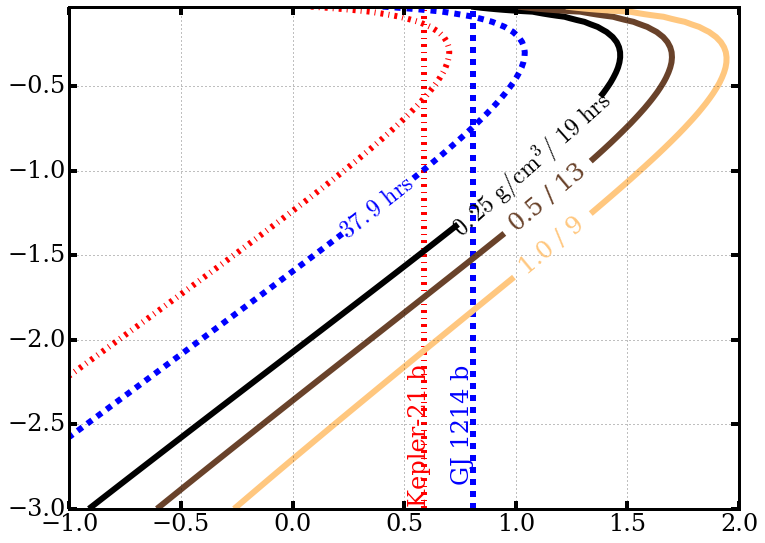

In [9]:
num_samples = 100

#Mcores = 10**(np.linspace(0., 2., num_samples))*cds.Mgeo
Mcores = 10**(np.linspace(-1., 2., num_samples))*cds.Mgeo
fenvs = 10**(np.linspace(-3., 0., num_samples + 1))
#Drop the very last one so I don't get a divide-by-zero error
fenvs = fenvs[:-1]

density = np.empty((len(Mcores), len(fenvs)))
Ps_Roche = np.empty((len(Mcores), len(fenvs)))
Mps = np.empty((len(Mcores), len(fenvs)))
Rps = np.empty((len(Mcores), len(fenvs)))
for i in range(len(Mcores)):
    for j in range(len(fenvs)):
        
        cur_Mp = Mcores[i]/(1. - fenvs[j])
        Mps[i,j] = cur_Mp.value
        cur_Rp = Lopez_superearth_radius(cur_Mp, fenv=fenvs[j], age=30e6*u.year)*cds.Rgeo
        Rps[i,j] = cur_Rp.value
        density[i,j] = (cur_Mp/(4.*np.pi/3.*(cur_Rp)**3)).to('g/cm^3').value
        Ps_Roche[i,j] = Rappaport_Roche_limit(rhop=density[i,j]*u.g/u.cm**3, incompressible=False).to('hour').value

fenvs = np.outer(np.ones_like(fenvs), fenvs)
Mcores = np.outer(Mcores, np.ones_like(Mcores))

fig = plt.figure(figsize=(9*aspect_ratio, 9))
ax = fig.add_subplot(111)

lvls = [0.25, 0.5, 1.]
density_lvls = Rappaport_Roche_limit(rhop=lvls*u.g/u.cm**3, incompressible=False).to('hour').value
#locs = [(0.5, -1.25), (0.5, -1.25), (0.5, -1.5), (0.5, -2.25), (1.25, -2)]
locs = [(1.1, -1.), (1.2, -1.25), (1.2, -1.5)]
fmt = {lvls[0]: '$%.2f\ {\\rm g/cm^3}/\ %i\ {\\rm hrs}$' % (lvls[0], density_lvls[0])}
fmt.update({lvls[i]: '%.1f / %i' % (lvls[i], density_lvls[i]) for i in range(1, len(lvls))})
CS = ax.contour(np.log10(Mcores), np.log10(fenvs), density, levels=lvls, cmap='copper', linewidths=6)
ax.clabel(CS, inline=1, fontsize=24, fmt=fmt, manual=locs)

#GJ 1214 b -- https://en.wikipedia.org/wiki/Gliese_1214_b
# Mp_lvls = [6.55]
# Rp_lvls = [2.678]
P_lvls = [1.58040456*24.]
#
#From Lopez & Fortney
#fenv = 0.0383
fenv = 0.00678 #The result using the new fiducial age of 30 Myrs, see below
Mcore = 6.46*(1. - fenv)
density = 1.870 #Wikipedia
ax.axvline(np.log10(Mcore), zorder=-1, color='blue', lw=6, ls='--')
ax.text(np.log10(Mcore)*0.88, -2.25, 'GJ 1214 b', rotation='vertical', color='blue', fontsize=24)
CS = ax.contour(np.log10(Mcores), np.log10(fenvs), Ps_Roche, colors='blue', levels=P_lvls, linestyles='--', linewidths=6)
fmt = {P_lvls[0]: '$%.1f\ {\\rm hrs}$' % P_lvls[0]}
locs = [(0.4, -1.25)]
ax.clabel(CS, inline=1, fontsize=24, fmt=fmt, manual=locs)
#ax.text(0.25, -0.55, '%i hours' % P_lvls[0], rotation=40, fontsize=24, color='b')

#Kepler-21 b
P_lvls = [exoplanets_table['PER'][exoplanets_table['NAME'] == 'Kepler-21 b']*24.]
fenv = exoplanets_table['fenv'][exoplanets_table['NAME'] == 'Kepler-21 b'] #The result using the new fiducial age of 30 Myrs, see below
Mcore = exoplanets_table['Mcore'][exoplanets_table['NAME'] == 'Kepler-21 b']
ax.axvline(np.log10(Mcore), zorder=-1, color='red', lw=6, ls='-.')
ax.text(np.log10(Mcore)*0.88, -2.25, 'Kepler-21 b', rotation='vertical', color='red', fontsize=24)
CS = ax.contour(np.log10(Mcores), np.log10(fenvs), Ps_Roche, colors='red', levels=P_lvls, linestyles='-.', linewidths=6)
fmt = {P_lvls[0]: '$%.1f\ {\\rm hrs}$' % P_lvls[0]}
locs = [(0.4, -1.25)]
ax.clabel(CS, inline=1, fontsize=24, fmt=fmt, manual=locs)

#CoRoT-7 b -- Lopez & Fortney (2013)
# Mcore = 7.42
# P_lvls = [0.853585*24.]
# ax.axvline(np.log10(Mcore), color='red', zorder=-1, linestyle='-.', linewidth=6)
# ax.text(np.log10(Mcore)*1.02, -2.25, 'CoRoT-7 b', rotation='vertical', color='red', fontsize=24)
# CS = ax.contour(np.log10(Mcores), np.log10(fenvs), Ps_Roche, colors='red', levels=P_lvls, linestyles='-.', linewidths=6)
# ax.text(0.25, -0.9, '%i hours' % P_lvls[0], rotation=30, fontsize=24, color='r')

#Kepler-446 b -- http://exoplanets.org/detail/Kepler-446_b
# Mcore = 3.657
# ax.axvline(np.log10(Mcore), color='red')
# CS = ax.contour(np.log10(Mcores), np.log10(fenvs), Ps_Roche, colors='blue', linewidths=8, levels=P_lvls)
# Rp_lvls = [2.678]

#GJ 436 b -- https://en.wikipedia.org/wiki/Gliese_436_b
# Mcore = 23.0*(1. - 0.12)
# # Rp_lvls = [4.327]
# P_lvls = [2.643904*24.]
# ax.axvline(np.log10(Mcore), color='green', zorder=-1, linestyle=':', linewidth=6)
# ax.text(np.log10(Mcore)*0.93, -2, 'GJ 436 b', rotation='vertical', color='green', fontsize=24)
# CS = ax.contour(np.log10(Mcores), np.log10(fenvs), Ps_Roche, colors='green', levels=P_lvls, linestyles=':', linewidths=6)
# ax.text(0., -0.4, '%i hours' % P_lvls[0], rotation=45, fontsize=24, color='g')

#Kepler-78 b -- https://en.wikipedia.org/wiki/Kepler-78b
Mcore = 1.77
P_lvls = [0.355007*24.]
ax.axvline(np.log10(Mcore), color='green', zorder=-1, linestyle=':', linewidth=6)
ax.text(np.log10(Mcore)*1.1, -2.25, 'Kepler-78 b', rotation='vertical', color='green', fontsize=24)
CS = ax.contour(np.log10(Mcores), np.log10(fenvs), Ps_Roche, colors='green', levels=P_lvls, linestyles=':', linewidths=6)
fmt = {P_lvls[0]: '$%.1f\ {\\rm hrs}$' % P_lvls[0]}
locs = [(1.5, -1.5)]
ax.clabel(CS, inline=1, fontsize=24, fmt=fmt, manual=locs)

ax.set_xlabel('$\\log_{10} \\left( M_{\\rm core}/{\\rm M_{Earth}}\\right)$', fontsize=36)
ax.set_ylabel('$\\log_{10}\ f_{\\rm env}$', fontsize=36)

ax.set_xlim([0, 2])
ax.set_ylim([-3.1, 0.1])

#fig.savefig('LopezFortney2014_density-PRoche_contours.eps', dpi=1000, bbox_inches='tight')

Now to convert these masses and radii to Roche limit periods.

In [10]:
c = cntr.Cntr(Mcores, fenvs, Ps_Roche)
level = 56.
Mcores_P, fenvs_P = (c.trace(level))[0].T
mx_ind = np.argmax(Mcores_P)
print(Mcores_P[mx_ind])

6.40326927723


In [11]:
def find_turnover_Mcore(period):
    c = cntr.Cntr(Mcores, fenvs, Ps_Roche)
    
    if(len(c.trace(period)) == 0.):
        return 0.
    
    Mcores_P, fenvs_P = (c.trace(period))[0].T
    return Mcores_P.max()

(10, 300)

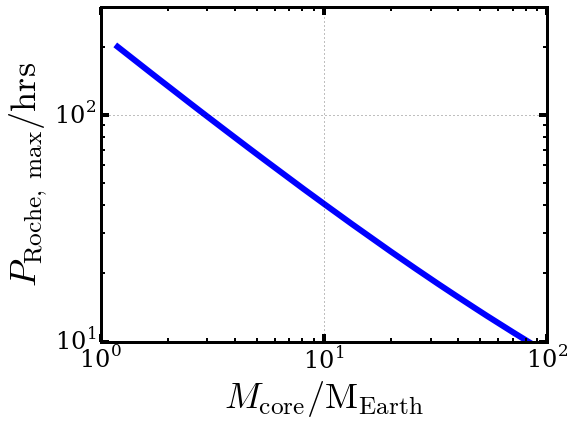

In [14]:
fig = plt.figure(figsize=(6*4./3, 6))
ax = fig.add_subplot(111)

periods = (np.linspace(3., 200., 198))[::-1]
turnover_Mcores = np.zeros_like(periods)
for i in range(len(periods)):
    turnover_Mcores[i] = find_turnover_Mcore(periods[i])
    
ax.loglog(turnover_Mcores, periods, lw=6)
ax.set_xlabel('$M_{\\rm core}/{\\rm M_{Earth}}$', fontsize=36)
ax.set_ylabel('$P_{\\rm Roche,\ max}/{\\rm hrs}$', fontsize=36)

ax.set_ylim([10, 300])

#fig.savefig('PRoche-max_vs_Mcore.eps', dpi=1000, bbox_inches='tight')

In [15]:
#Convert from Mcore to PRoche, max
def find_turnover_period(Mcore):
    return np.interp(Mcore, turnover_Mcores, periods)
    
print(find_turnover_period(3.85))

81.6338867712


In [37]:
#Attempting to figure out whether GJ 1214 b could have moved from the expected Pturnover to the observed P with 
#  some reasonable Q*
Ms = 0.157
Rs = 0.2064
fenv = 0.00678 #The result using the new fiducial age of 30 Myrs, see below
Mp = 6.46
Rp = 2.67
Mcore = Mp*(1. - fenv)
P = find_turnover_period(Mcore) #hours

a0 = Keplers_Third_Law(P=P*u.hour, Mstar=Ms*cds.Msun)
a = Keplers_Third_Law(P=1.58040456*u.day, Mstar=Ms*cds.Msun)

print("qs = 5")
print((tidal_decay_time(a0=a0, a=a, Mstar=Ms*cds.Msun, 
                     Rstar=Rs*cds.Rsun, Mp=Mp*cds.Mgeo, Qstar=1e5)).to('year').value/1e9)
print("Gyrs")

print("time left:")
print((tidal_decay_time(a0=a, a=Rs*cds.Rsun, Mstar=Ms*cds.Msun, 
                     Rstar=Rs*cds.Rsun, Mp=Mcore*cds.Mgeo, Qstar=1e5)).to('year').value/1e9)
print("Gyrs")

print("qs = 4")
print((tidal_decay_time(a0=a0, a=a, Mstar=Ms*cds.Msun, 
                     Rstar=Rs*cds.Rsun, Mp=Mp*cds.Mgeo, Qstar=1e4)).to('year').value/1e9)
print("Gyrs")

print("PRoche: %g" % Rappaport_Roche_limit(Mp=Mp*cds.Mgeo, Rp=Rp*cds.Rgeo).to('hour').value)
aRoche = Keplers_Third_Law(P=Rappaport_Roche_limit(Mp=Mp*cds.Mgeo, Rp=Rp*cds.Rgeo), Mstar=Ms*cds.Msun)
print("time left:")
print((tidal_decay_time(a0=a, a=aRoche, Mstar=Ms*cds.Msun, 
                     Rstar=Rs*cds.Rsun, Mp=Mcore*cds.Mgeo, Qstar=1e4)).to('year').value/1e9)
print("Gyrs")

qs = 5
61.7843066117
Gyrs
time left:
14.2171600633
Gyrs
qs = 4
6.17843066117
Gyrs
PRoche: 7.02857
time left:
1.42076033185
Gyrs


In [42]:
#Attempting to figure out whether Kepler-21 b could have moved from the expected Pturnover to the observed P with 
#  some reasonable Q*
Ms = 1.34
Rs = 1.86
Mcore = 3.860613724
Mp = Mcore #basically the same
Rp = float(exoplanets_table['R'][exoplanets_table['NAME'] == 'Kepler-21 b'])
P = find_turnover_period(Mcore) #hours

a0 = Keplers_Third_Law(P=P*u.hour, Mstar=Ms*cds.Msun)
a = Keplers_Third_Law(P=2.785755*u.day, Mstar=Ms*cds.Msun)
print((tidal_decay_time(a0=a0, a=a, Mstar=Ms*cds.Msun, 
                     Rstar=Rs*cds.Rsun, Mp=Mcore*cds.Mgeo, Qstar=1e5)).to('year').value/1e9)
print("Gyrs")

print("PRoche: %g" % Rappaport_Roche_limit(Mp=Mp*cds.Mgeo, Rp=Rp*cds.Rgeo).to('hour').value)
aRoche = Keplers_Third_Law(P=Rappaport_Roche_limit(Mp=Mp*cds.Mgeo, Rp=Rp*cds.Rgeo), Mstar=Ms*cds.Msun)
print("time left:")
print((tidal_decay_time(a0=a, a=aRoche, Mstar=Ms*cds.Msun, 
                     Rstar=Rs*cds.Rsun, Mp=Mcore*cds.Mgeo, Qstar=1e5)).to('year').value/1e9)
print("Gyrs")

1.91115731887
Gyrs
PRoche: 4.35833
time left:
1.41054059713
Gyrs


In [233]:
#Attempting to figure out whether Kepler-78 b could have moved from the expected Pturnover to the observed P with 
#  some reasonable Q*
#
#Parameters from exoplanet.eu
Ms = 0.81
Rs = 0.74
Mcore = 1.69 #Earths
P = find_turnover_period(Mcore)

a0 = Keplers_Third_Law(P=P*u.hour, Mstar=Ms*cds.Msun)
a = Keplers_Third_Law(P=0.35500745*u.day, Mstar=Ms*cds.Msun)

print((tidal_decay_time(a0=a0, a=a, Mstar=Ms*cds.Msun, 
                     Rstar=Rs*cds.Rsun, Mp=Mp*cds.Mgeo, Qstar=1e5)).to('year').value/1e9)
print("Gyrs")

1316.73787775
Gyrs


/Users/brian/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log10
/Users/brian/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in log10
/Users/brian/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: RuntimeWarning: divide by zero encountered in log10


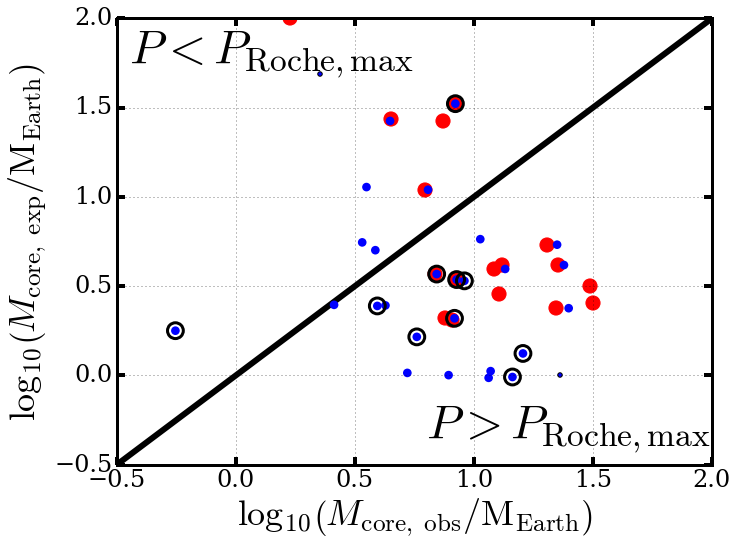

In [20]:
fig = plt.figure(figsize=(8*4./3,8))
ax = fig.add_subplot(111)

ind = np.where(LF_Table7['PER'] < 6.)
ax.scatter(LF_Table7['PER'], LF_Table7['Mcore'])

turnover_Mcore = []
for cur_per in LF_Table7['PER'][ind]:
    turnover_Mcore = np.append(turnover_Mcore, find_turnover_Mcore(cur_per*24.))
ax.scatter(np.log10(LF_Table7['Mcore'][ind]), np.log10(turnover_Mcore), s=200, color='red')

xyrange = [-0.5, 2.]
ax.plot(xyrange, xyrange, lw=6, zorder=-1, color='k')

#and then add the ones I calculated
turnover_Mcore = []
for cur_per in exoplanets_table['PER']:
    turnover_Mcore = np.append(turnover_Mcore, find_turnover_Mcore(cur_per*24.))
ax.scatter(np.log10(exoplanets_table['Mcore']), np.log10(turnover_Mcore), s=75, edgecolors='none')

ind = np.where(exoplanets_table['MULT'] != 0)
turnover_Mcore = []
for cur_per in exoplanets_table['PER'][ind]:
    turnover_Mcore = np.append(turnover_Mcore, find_turnover_Mcore(cur_per*24.))
ax.scatter(np.log10(exoplanets_table['Mcore'][ind]), np.log10(turnover_Mcore), s=250, marker='o', 
           facecolors='none', edgecolors='black', lw=3)

ax.set_xlim(xyrange)
ax.set_ylim(xyrange)

ax.text(-0.45, 1.75, '$P < P_{\\rm Roche, max}$', fontsize=48)
ax.text(0.8, -0.35, '$P > P_{\\rm Roche, max}$', fontsize=48)

ax.set_xlabel('$\\log_{10}\\left( M_{\\rm core,\ obs}/{\\rm M_{Earth}} \\right)$', fontsize=36)
ax.set_ylabel('$\\log_{10}\\left( M_{\\rm core,\ exp}/{\\rm M_{Earth}} \\right)$', fontsize=36)

# #fig.savefig('Mcore-exp_vs_Mcore-obs.eps', dpi=1000, bbox_inches='tight')


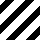
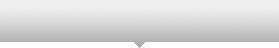
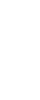
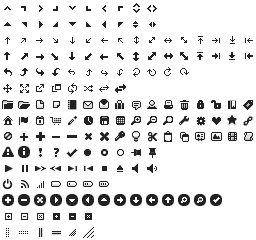
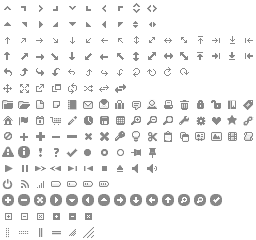
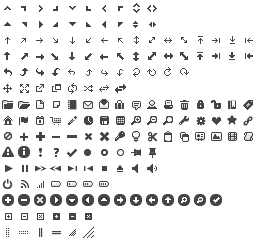
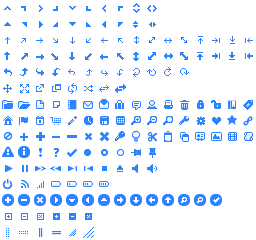
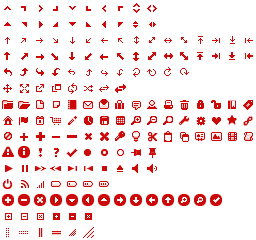
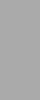
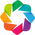
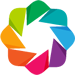
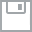
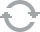
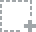
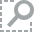
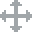
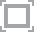
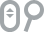

In [77]:
#Use bokeh to make interactive plots
import bokeh.plotting
bokeh.plotting.output_notebook()

from collections import OrderedDict
from bokeh.plotting import figure, show, ColumnDataSource, output_file
from bokeh.models import HoverTool

# output to static HTML file
#output_file("Ltot-Lcrit.html", title="Total to Critical Angular Momenta Ratio")

source = ColumnDataSource(
    data=dict(
        lMobs=np.log10(exoplanets_table['Mcore'][ind]),
        lMexp=np.log10(turnover_Mcore),
        name=exoplanets_table['NAME'][ind],
    )
)

hover = HoverTool(
    tooltips = [
        ("(log10(Mobs), log10(Mexp))", "(@lMobs, @lMexp)"),
        ("name ", "@name"),
    ]
)

p1 = figure(tools=[hover,'wheel_zoom,box_zoom,save,reset,pan'], y_range=[-0.5, 2], x_range=[-0.5, 2])
p1.scatter('lMobs', 'lMexp', source=source, size=5)
#p1.line(np.linspace(-0.5, 2, 100), np.linspace(-0.5, 2, 100))
p1.xaxis.axis_label="log10(Mobs)"
p1.yaxis.axis_label="log10(Mexp)"

show(p1)

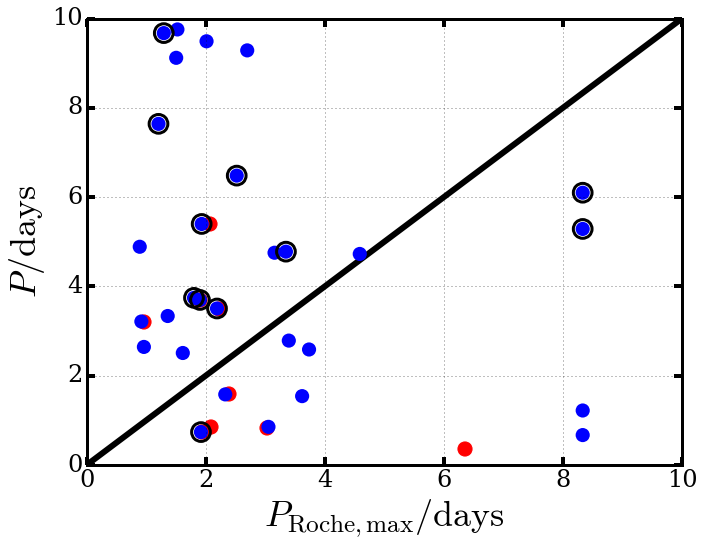

In [42]:
fig = plt.figure(figsize=(8*4./3,8))
ax = fig.add_subplot(111)

ind = (LF_Table7['PER'] < 6.) & (LF_Table7['H/He Envelope Fraction'] < 0.1)
#ax.scatter(LF_Table7['PER'], LF_Table7['Mcore'])

PRoche_max = np.array([])
for cur_Mcore in LF_Table7['Mcore'][ind]:
    PRoche_max = np.append(PRoche_max, find_turnover_period(cur_Mcore))
ax.scatter(PRoche_max/24., LF_Table7['PER'][ind], s=200, color='red')

xyrange = [0., 10.]
ax.plot(xyrange, xyrange, lw=6, zorder=-1, color='k')

# #and then add the ones I calculated
PRoche_max = np.array([])
for cur_Mcore in exoplanets_table['Mcore']:
    PRoche_max = np.append(PRoche_max, find_turnover_period(cur_Mcore))
ax.scatter(PRoche_max/24, exoplanets_table['PER'], s=200, edgecolors='none')

ind = np.where(exoplanets_table['MULT'] != 0)
PRoche_max = np.array([])
for cur_Mcore in exoplanets_table['Mcore'][ind]:
    PRoche_max = np.append(PRoche_max, find_turnover_period(cur_Mcore))

ax.scatter(PRoche_max/24, exoplanets_table['PER'][ind], s=350, marker='o', facecolors='none', edgecolors='black', lw=3)
    
ax.set_xlim(xyrange)
ax.set_ylim(xyrange)

ax.set_ylabel('$P/{\\rm days}$', fontsize=36)
ax.set_xlabel('$P_{\\rm Roche, max}/{\\rm days}$', fontsize=36)

fig.savefig('P_vs_PRoche-max.eps', dpi=1000, bbox_inches='tight')

In [38]:
ind = (LF_Table7['PER'] < 6.) & (LF_Table7['H/He Envelope Fraction'] < 0.1)
#ax.scatter(LF_Table7['PER'], LF_Table7['Mcore'])

PRoche_max = np.array([])
for cur_Mcore in LF_Table7['Mcore'][ind]:
    PRoche_max = np.append(PRoche_max, find_turnover_period(cur_Mcore)/24.)

# output to static HTML file
#output_file("Ltot-Lcrit.html", title="Total to Critical Angular Momenta Ratio")

source = ColumnDataSource(
    data=dict(
        Pobs=LF_Table7['PER'][ind],
        PRoche_max=PRoche_max,
        name=LF_Table7['Planet Name'][ind],
    )
)

hover = HoverTool(
    tooltips = [
        ("P, PRoche_max", "(@Pobs, @PRoche_max)"),
        ("name ", "@name"),
    ]
)

p1 = figure(tools=[hover,'wheel_zoom,box_zoom,save,reset,pan'])
p1.scatter('PRoche_max', 'Pobs', source=source, size=20, color='red', xrange=[0, 10], yrange=[0, 10])

PRoche_max = np.array([])
for cur_Mcore in exoplanets_table['Mcore']:
    PRoche_max = np.append(PRoche_max, find_turnover_period(cur_Mcore)/24.)

source = ColumnDataSource(
    data=dict(
        Pobs=exoplanets_table['PER'],
        PRoche_max=PRoche_max,
        name=exoplanets_table['NAME'],
    )
)
p1.scatter('PRoche_max', 'Pobs', source=source, size=15, color='blue')

p1.yaxis.axis_label="Pobs"
p1.xaxis.axis_label="PRoche_max"

show(p1)

In [ ]:
#fig = plt.figure(figsize=(8,8))
fig = plt.figure(figsize=(default_fig_width,default_fig_height))
ax = fig.add_subplot(111)

ind = np.where(LF_Table7['PER'] < 3.)
#ax.scatter(LF_Table7['PER'], LF_Table7['Mcore'])

turnover_Mcore = []
for cur_per in LF_Table7['PER'][ind]:
    turnover_Mcore = np.append(turnover_Mcore, find_turnover_Mcore(cur_per*24.))
ax.scatter(np.log10(LF_Table7['Mcore'][ind]), np.log10(turnover_Mcore), s=200, facecolor='red', edgecolor='black', 
           label='L&F (2013)')

xyrange = [-0.5, 2.]
ax.plot(xyrange, xyrange, lw=6, zorder=-1, color='k')

#and then add the ones I calculated
ind = np.where(exoplanets_table['PER (day)'] < 3.)
turnover_Mcore = []
for cur_per in exoplanets_table['PER (day)'][ind]:
    turnover_Mcore = np.append(turnover_Mcore, find_turnover_Mcore(cur_per*24.))
ax.scatter(np.log10(exoplanets_table['Mcore'][ind]), np.log10(turnover_Mcore), s=200, marker='.', 
           facecolor='blue', edgecolor='black', zorder=0, label='This work')

ax.set_xlim(xyrange)
ax.set_ylim(xyrange)

ax.text(-0.5, 1.75, '$P < P_{\\rm turnover}$', fontsize=36)
ax.text(1, -0.35, '$P > P_{\\rm turnover}$', fontsize=36)

ax.set_xlabel('$\\log_{10}\\left( M_{\\rm core,\ obs}/{\\rm M_{Earth}} \\right)$', fontsize=36)
ax.set_ylabel('$\\log_{10}\\left( M_{\\rm core,\ exp}/{\\rm M_{Earth}} \\right)$', fontsize=36)

ax.legend(loc='upper right', fontsize=20, scatterpoints=1)
#fig.savefig('P-vs-Pturnover.eps', dpi=1000, bbox_inches='tight')

Make Roche period plot

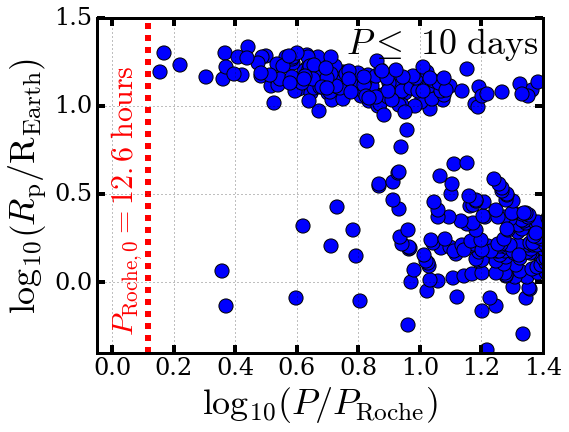

In [6]:
fig = plt.figure(figsize=(default_fig_width, default_fig_height))
ax = fig.add_subplot(111)

exoplanets_table = Table.read('exoplanets-org_2015Dec7.csv', format='ascii.csv')

#ind = np.where(exoplanets_table['PER (day)'] < 3.)
ind = np.where(exoplanets_table['PER (day)'] < 10.)
exoplanets_table['PRoche (days)'] = \
    Rappaport_Roche_limit(exoplanets_table['MASS (Mearth)']*cds.Mgeo, exoplanets_table['R (Rearth)']*cds.Rgeo)

x = exoplanets_table['PER (day)'][ind]/exoplanets_table['PRoche (days)'][ind]
y = exoplanets_table['R (Rearth)'][ind]
ax.scatter(np.log10(x), np.log10(y), s=200)

#    period0 = 12.6/24.*u.day #days
#For a planet comprised of a highly compressible fluid
#ax.axvline(0., lw=6, ls='--', color='k', zorder=-1)

#Add in 12.6-hour Roche limit
#  A body comprised of an incompressible fluid with negligible bulk tensile strength
ax.axvline(np.log10(12.6/9.6), lw=6, ls='--', color='red', zorder=-1)
ax.text(-0.01, 1.1, '$P_{\\rm Roche, 0} = {\\rm 12.6\ hours}$', rotation=90, fontsize=30, 
        color='red')

ax.set_xlim([-0.05, 1.4])
ax.set_ylim([-0.4, 1.5])

#ax.fill_between([-0.3, 0.], -0.4, 1.4, color='lightgrey', zorder=-1)

ax.set_xlabel('$\\log_{\\rm 10} \\left( P/P_{\\rm Roche} \\right)$', fontsize=36)
ax.set_ylabel('$\\log_{\\rm 10} \\left( R_{\\rm p}/{\\rm R_{Earth}} \\right)$', fontsize=36)

#ax.text(0.8, 1.3, '$P \\leq\ {\\rm 3\ days}$', fontsize=36)
ax.text(0.76, 1.3, '$P \\leq\ {\\rm 10\ days}$', fontsize=36)
fig.savefig('P-PRoche.eps', dpi=1000, bbox_inches='tight')

In [4]:
Mp = 1.*cds.Mjup
Rp = 1.*cds.Rjup
rhop = (Mp/(4.*np.pi/3.*Rp**3.)).to('g/cm^3')
Ms = 1.*cds.Msun

a0 = 0.02*cds.AU
print(Keplers_Third_Law(a=a0).to('day'))

Roche_period = Rappaport_Roche_limit(rhop=rhop)
print(Roche_period)
a_Roche = Keplers_Third_Law(P=Roche_period, Mstar=Ms)
print(tidal_decay_time(a0=a0, a=a_Roche, Qstar=1e5).to('year')/1e6)
print(tidal_decay_time(a0=a0, a=a_Roche, Qstar=1e9).to('year')/1e6)

1.03308300731 d
0.359138769919 d
2.35055634789 yr
23505.5634789 yr
